Missing Value: 
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Dataset shape: (4431, 7)
Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4431 non-null   object 
 1   Open       4431 non-null   float64
 2   High       4431 non-null   float64
 3   Low        4431 non-null   float64
 4   Close      4431 non-null   float64
 5   Adj Close  4431 non-null   float64
 6   Volume     4431 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 242.4+ KB
Info:
 None
Summary statistics:
               Open         High          Low        Close    Adj Close  \
count  4431.000000  4431.000000  4431.000000  4431.000000  4431.000000   
mean    693.087345   699.735595  

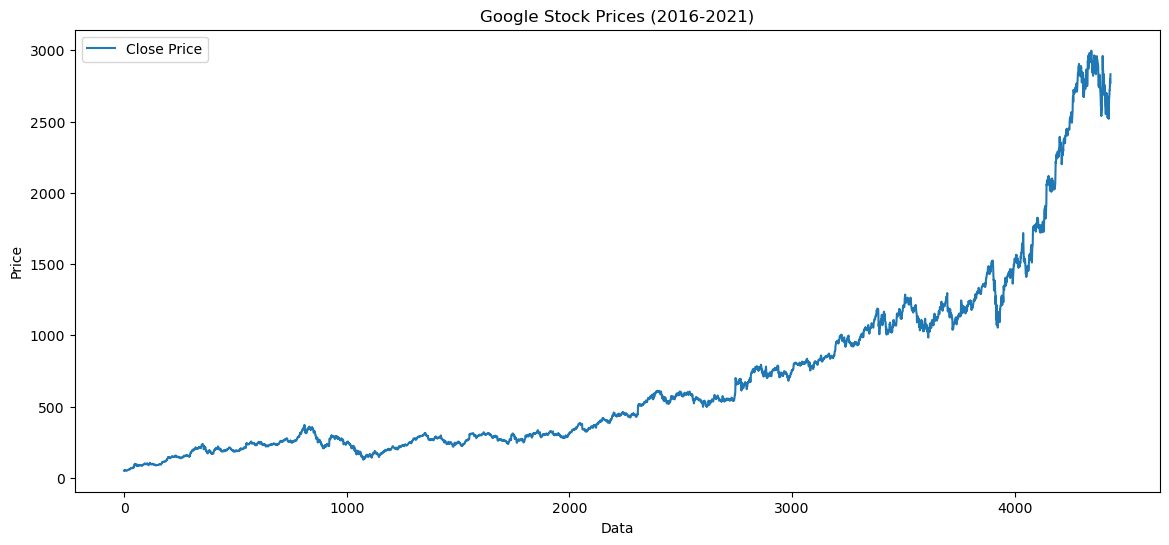

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 100)           42800     
                                                                 
 dropout_6 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_7 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                

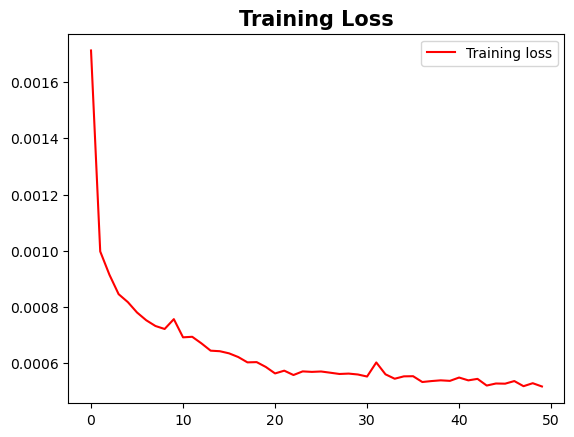

<Figure size 640x480 with 0 Axes>

Train loss: [0.0004721518780570477, 0.4985697865486145]
Test loss: [0.004826450254768133, 0.38285714387893677]
28/28 [==============================] - 2s 34ms/step
Prediction time: 2.0811264514923096 seconds


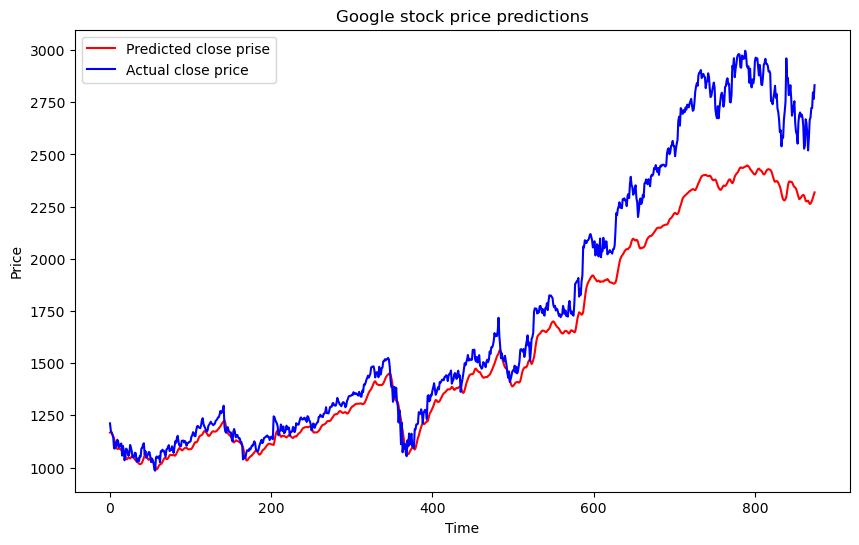

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import time

data = pd.read_csv('GOOGL.csv')

data_copy = data.copy()

data_copy.dropna(inplace=True)

selected_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data_copy = data_copy[selected_features]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_copy)

df = pd.DataFrame(data)
df.head

missing_values = df.isnull().sum()
print("Missing Value: \n", missing_values)

print("Dataset shape:", df.shape)
print("Columns:", df.columns)
print("Info:\n", df.info())
print("Summary statistics:\n", df.describe())

plt.figure(figsize=(14,6))
plt.plot(data['Close'], label ='Close Price')
plt.title('Google Stock Prices (2016-2021)')
plt.xlabel('Data')
plt.ylabel('Price')
plt.legend()
plt.show()

df['Date'] = pd.to_datetime(df['Date'], utc=True)
df.head()

def prepare_data(data, time_steps):
    X,y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 60

X,y = prepare_data(scaled_data, time_steps)

split_ratio = 0.8
split_index = int(split_ratio*len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=100, return_sequences=True),
    Dropout(0.2),
    LSTM(units=100),
    Dropout(0.2),
    Dense(units=len(selected_features))
])

#compile moel
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# display model
print(model.summary())

# measure training time
start_time = time.time()

history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

training_time = time.time() - start_time
print("Training Time:", training_time, "seconds")

loss = history.history['loss']

epoch = range(len(loss))

plt.plot(epoch, loss, 'r', label='Training loss')
plt.title('Training Loss', size=15, weight ='bold')
plt.legend()
plt.figure()
plt.show()

# model evaluation
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f"Train loss: {train_loss}")
print(f"Test loss: {test_loss}")

#Measure predictionn time
start_time = time.time()

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

prediction_time = time.time()-start_time
print("Prediction time:", prediction_time, "seconds")

# predicted vs actual
plt.figure(figsize=(10,6))
plt.plot(predictions[:,3], label='Predicted close prise', color='r')
plt.plot(y_test_inverse[:,3], label='Actual close price', color='b')
plt.title('Google stock price predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

